#Assignment 2
#Author: Syed Kumayl Raza Moosavi - 364013

#The x and y coordination and the annotations are stored in .npy files. 
#Use Python numpy to read the files separated with a semi-colon.

#Expression: expression ID of the face 
#(0: Neutral, 1: Happy, 2: Sad, 3: Surprise, 4:Fear, 5: Disgust, 6: Anger, 7: Contempt)

#Valence: valence value of the expression in interval [-1,+1] (for Uncertain and Noface categories the value is -2)
    #Continuous values from -1 (negative/unpleasant) to +1 (positive/pleasant)
    
#Arousal: arousal value of the expression in interval [-1,+1] (for Uncertain and No-face categories the value is -2)
    #Continuous values from -1 (Tired) to +1 (Active)
    
#Task:
#----> Use appropriate CNN architecture recognition of Facial Expression, and computing Valence and Arousal
#----> use at least two CNN baselines (VGG, ResNet, Inception, Xception, MobileNet, EfficientNet, SE Net, DenseNet or any other … etc)

Part 2

Data is very large. So we will use a custom data generator to load batches of data from the files and then train on each batch simultaneously using the GPU of the computer

In [1]:
###With python 3.7 these two are compatible versions of tensorflow and cudatoolkit that will enable GPU from PC
#Create a new environment in anaconda for installing previous versions

#!pip install tensorflow==2.2
#!pip install cudatoolkit==10.1

#!pip install scikit-image
#!pip install pandas
#!pip install matplotlib
#!pip install krippendorff

#I have tensorflow 2.2 installed so compatible addon is:
#!pip install tensorflow-addons==0.11.2


import numpy as np
import os
import glob

import skimage.io as io
import pandas as pd
import cv2
import krippendorff

from matplotlib import pyplot as plt
import random
import tensorflow as tf
import pathlib
from matplotlib.patches import Circle
import cv2

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 30 21:34:45 2022

@author: moosa
"""

from pathlib import Path
import os
import random
from PIL import Image


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_folder, npy_folder, batch_size, shuffle=True):
        self.batch_size = batch_size
#         self.df = dataframe
#         self.num_classes = num_classes
        self.shuffle = shuffle
        self.img_folder = img_folder
        self.npy_folder = npy_folder
#         self.on_epoch_end()
        self.img_list = os.listdir(img_folder)
        self.indices = np.arange(0, len(self.img_list))
        if self.shuffle:
            random.shuffle(self.img_list)

    def __len__(self):
        return int(np.ceil(len(os.listdir(self.img_folder)) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size <= len(os.listdir(self.img_folder)):
            
            index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        else:
            roll_over = (index + 1) * self.batch_size -  len(os.listdir(self.img_folder))
            index = np.array(self.indices[index * self.batch_size:].tolist() + self.indices[0:roll_over+1].tolist())
        batch = [self.indices[k] for k in index]
        
        [X,X2], [y, y2, y3] = self.__get_data(batch)
        return [X,X2], [y, y2, y3]


    def __get_data(self, batch):
        
        X = []
        X2 = []
        y = []
        y2 = []
        y3 = []
        
        for i, id in enumerate(batch):
            img_name = self.img_list[id]
            aro = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_aro.npy')).astype('float32')
            expa = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_exp.npy'))
            exp = to_categorical(expa,num_classes = 8)
            lnd = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_lnd.npy')).reshape(68,2)
            val = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_val.npy')).astype('float32')
            
            img = Image.open(os.path.join(self.img_folder,img_name)).convert('RGB')
            img = tf.keras.preprocessing.image.img_to_array(img)
            X.append((img))
            X2.append((lnd))
            y.append((aro))
            y2.append((val))
            y3.append((exp))            
        return [np.array(X),np.array(X2)], [np.array(y),np.array(y2),np.array(y3)]

In [3]:
def show(xx,yy,y1,y2,y3): 
    fig,ax = plt.subplots(1)
    #ax.set_aspect('equal')
    plt.imshow(xx.astype("uint8"))
    ax.text(5, 5, y3, bbox={'facecolor': 'white', 'pad': 10})
    
    #ax.text(5, 200, 'Arousal: 'y1, bbox={'facecolor': 'white', 'pad': 10})
    plt.scatter(yy[:, 0], yy[:, 1], s=10, marker='.')
    plt.pause(0.001)  # pause a bit so that plots are updated

4495
Arousal : 0.0950652 Valence : 0.805894


C:\Users\moosa\anaconda3\envs\kumi\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


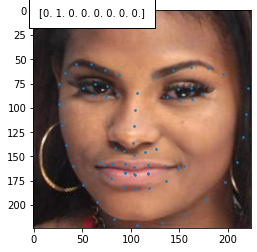

Arousal : 0.373016 Valence : -0.611111


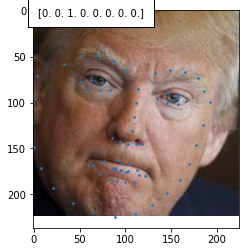

Arousal : -0.0431332 Valence : -0.0862664


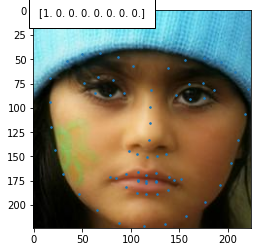

Arousal : 0.221239 Valence : -0.39507


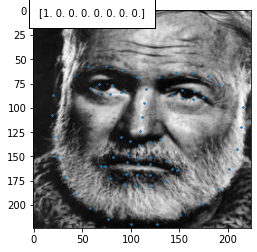

Arousal : 0.241967 Valence : 0.856562


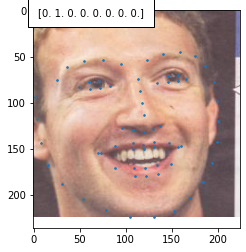

In [4]:
import time
from tensorflow.keras.utils import to_categorical
#using data generators for training of models
data = DataGenerator('train_and_val_set-002/train_set/images', 'train_and_val_set-002/train_set/annotations', batch_size=64)
print(len(data))
i=0
for X,y in data:
    i=i+1
    print("Arousal :", y[0][0],"Valence :", y[1][0])
    show(X[0][0],X[1][0],y[0][0],y[1][0],y[2][0])
    
    #See random images with landmarks for 5 values then break generator
    if i==5:
        break

In [5]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def correlationMetric(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = K.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def CCC(y_true, y_pred):
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    
    The concordance correlation coefficient is the correlation between two variables that fall on the 45 degree line through the origin.
    
    It is a product of
    - precision (Pearson correlation coefficient) and
    - accuracy (closeness to 45 degree line)

    Interpretation:
    - `rho_c =  1` : perfect agreement
    - `rho_c =  0` : no agreement
    - `rho_c = -1` : perfect disagreement 
    
    Args: 
    - y_true: ground truth
    - y_pred: predicted values
    
    Returns:
    - concordance correlation coefficient (float)
    '''
    
    # covariance between y_true and y_pred
    N = K.int_shape(y_pred)[-1]
    s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # means
    x_m = K.mean(y_true)
    y_m = K.mean(y_pred)
    # variances
    s_x_sq = K.var(y_true)
    s_y_sq = K.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC


############Needed to install old version of tensorflow to activate the GPU of the computer. Took a long time to figure that out
############After installing old version of tensorflow cannot find compatible version of tensorflow-addons for these metrics

import tensorflow_addons as tfa
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient as CORR
from tensorflow_addons.metrics import CohenKappa as Cohen_Kappa
from tensorflow_addons.metrics import F1Score as F1_Score

Apply a Network and predict classification using image and landmark points according to the following model
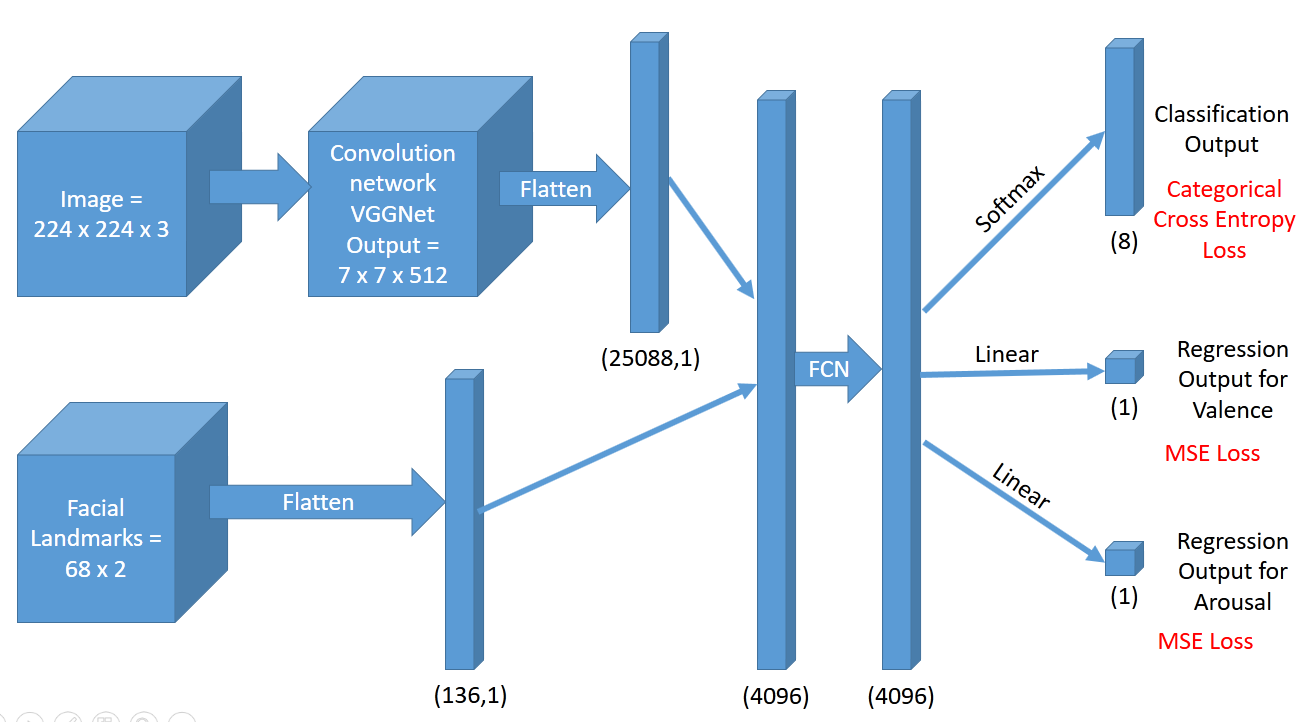

In [7]:
# Creating a CNN model with many VGG blocks

# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in
 
# define model input
visible = Input(shape=(224, 224, 3))  #image
visible2 = Input(shape=(68, 2))   #expressions


# add vgg module
layer1 = vgg_block(visible, 64, 2)
# add vgg module
layer2 = vgg_block(layer1, 128, 2)
# add vgg module
layer3 = vgg_block(layer2, 256, 3)
# add vgg module
layer4 = vgg_block(layer3, 512, 3)
# add vgg module
layer5 = vgg_block(layer4, 512, 3)

layer6_1 = Flatten()(layer5)
layer6_2 = Flatten()(visible2)

layer6 = concatenate([layer6_1, layer6_2])
layer7 = Dense(4096, activation='relu')(layer6)
layer8 = Dense(4096, activation='relu')(layer7)


# Output layer for classification (1000 classes)
layer_class = Dense(8, activation='softmax')(layer8)


layer_arousal = Dense(1, activation='linear')(layer8)

layer_val = Dense(1, activation='linear')(layer8)


classification_output = Lambda(lambda x:x, name = "classification_output")(layer_class)
arousal_output = Lambda(lambda x:x, name = "arousal_output")(layer_arousal)
valence_output = Lambda(lambda x:x, name = "valence_output")(layer_val)

# create model
model = Model(inputs=[visible,visible2], outputs=[arousal_output, valence_output, classification_output])


#macro parameters
model.compile(loss=['categorical_crossentropy', 'mse', 'mse'],
              optimizer='adam', metrics={"classification_output":['accuracy',
                                                                  Cohen_Kappa(num_classes=8),
                                                                  F1_Score(num_classes=8),
                                                                  AUC(curve='ROC',name = 'AUC-ROC'), 
                                                                  AUC(curve='PR',name = 'AUC-PR')], 
                                         "arousal_output":['RootMeanSquaredError',
                                                          correlationMetric, 
                                                           CCC], 
                                         "valence_output":['RootMeanSquaredError',
                                                          correlationMetric,
                                                           CCC]}, 
              run_eagerly=True)



# summarize model
model.summary()
# plot model architecture
#plot_model(model, show_shapes=True, to_file='vgg_block.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
#[print(i.shape, i.dtype) for i in model.inputs]
#[print(o.shape, o.dtype) for o in model.outputs]
#[print(l.name, l.input_shape, l.dtype) for l in model.layers]

In [9]:
import tensorflow as tf
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:

model.fit_generator(generator=DataGenerator('train_and_val_set-002/train_set/images', 'train_and_val_set-002/train_set/annotations', 
                                            batch_size=29), use_multiprocessing=False)

Instructions for updating:
Please use Model.fit, which supports generators.
9919/9919 [==============================] - 6820s 688ms/step - loss: 458778.7500 - arousal_output_loss: 1.4117e-08 - valence_output_loss: 458778.7500 - classification_output_loss: 0.2377 - arousal_output_root_mean_squared_error: 146.2614 - arousal_output_correlationMetric: 1.0050 - arousal_output_CCC: 4324.8003 - valence_output_root_mean_squared_error: 677.3321 - valence_output_correlationMetric: 0.5994 - valence_output_CCC: 45441168.0000 - classification_output_accuracy: 0.0491 - classification_output_cohen_kappa: 1.9550e-05 - classification_output_f1_score: 0.0119 - classification_output_AUC-ROC: 0.4566 - classification_output_AUC-PR: 0.1071


In [12]:
model.evaluate_generator(generator=DataGenerator('test_set/val_set/images', 'test_set/val_set/annotations', batch_size=29),
                    use_multiprocessing=False)

[3.364443302154541,
 4.216068205664669e-08,
 3.1457321643829346,
 0.2187109738588333,
 44.82633590698242,
 0.9610517024993896,
 4934.509765625,
 1.7736212015151978,
 0.7566516399383545,
 4109637.5,
 0.12515613436698914,
 0.0,
 array([0.        , 0.        , 0.        , 0.22246891, 0.        ,
        0.        , 0.        , 0.        ], dtype=float32),
 0.5000892281532288,
 0.12504640221595764]